In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import keras

from tensorflow.keras.layers import RandomTranslation, RandomZoom, RandomRotation

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path

project_root = Path().resolve().parent
if not project_root in [Path(p).resolve() for p in sys.path]:
    sys.path.append(str(project_root))

from src import PATHS

## pour ne travailler que sur un échantillon :

In [4]:
sample = pd.read_parquet(os.path.join(project_root,'data', 'metadata', 'samples', 'df_documents_sample_40k_1.parquet'), engine='fastparquet')

converted_prefix = os.path.join(project_root, 'data', 'converted')
sample['filepath'] = sample['rvl_image_path'].apply(lambda p: os.path.join(converted_prefix, p.replace("raw/", "").replace(".tif", ".jpg")))
sample = sample.drop(columns=['rvl_image_path', 'document_id', 'filename', 'iit_image_path', 'iit_individual_xml_path', 'iit_collective_xml_path'])

## création des sets train, test et validation

In [7]:
# 1. Encodage des labels : pas besoin ? 
label_encoder = LabelEncoder()
sample['label_encoded'] = label_encoder.fit_transform(sample['label'])

# 2. On part de sample pour créer les différents sets
df_train = sample[sample['data_set'] == 'train']
df_val = sample[sample['data_set'] == 'val']
df_test = sample[sample['data_set'] == 'test']

# 3. Fonction pour charger et prétraiter une image
def process_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3) #parce que VGG16 attend 3 canaux
    image = tf.image.resize(image, [224, 224])  # taille attendue par VGG16
    image = image / 255.0  # Normalisation entre 0 et 1
    return image, label

# 4. Création du dataset
def get_dataset(df_subset, shuffle=False):
    file_paths = df_subset['filepath'].values
    labels = df_subset['label_encoded'].values
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: process_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = get_dataset(df_train, shuffle=True)
val_ds = get_dataset(df_val)
test_ds = get_dataset(df_test)

In [8]:
len(train_ds) #attention c'est le nombre de batchs de 32 images, et il y en a 1 pas tout à fait rempli. Ce nombre est donc attendu.

1000

## On récupère le modèle VGG16 pour le réentrainer sur nos images

In [9]:
# Modèle VGG16
base_model = keras.applications.VGG16(weights='imagenet', include_top=False)

# Freezer les couches du VGG16
base_model.trainable = False

# Redégeler les couches après chargement
for layer in base_model.layers[-4:]:
    layer.trainable = True


# Création du modèle avec l'API Fonctionnelle
inputs = Input(shape=(224, 224, 3))

# Application des augmentations                          
#x = RandomTranslation(height_factor=0.1, width_factor=0.1)(inputs) 
#x = RandomZoom(0.1)(x)  

# Construction du modèle
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.2)(x)
outputs = Dense(16, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [11]:
early_stopping = EarlyStopping(
                                patience=5, # Attendre 5 epochs avant application
                                min_delta=0.001, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, 
    # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode='min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss",
                                        patience=5,        # attendre un peu plus
                                        min_delta=0.001,   # plus sensible
                                        factor=0.5,        # réduire plus doucement
                                        cooldown=3,
                                        min_lr=1e-6,
                                        verbose=1
                                    )

checkpoint = ModelCheckpoint( #retient le meilleur modèle
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [12]:
history_model = model.fit(train_ds, 
                          epochs=50,
                          validation_data=val_ds, 
                          callbacks = [reduce_learning_rate,
                                       early_stopping, 
                                       checkpoint])
# je ne touche pas au set de validation pour l'instant, seulement, quand j'aurai des résultats satisfaisants

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2998 - loss: 2.2204   
Epoch 1: val_loss improved from inf to 1.34033, saving model to best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1288s 1s/step - accuracy: 0.2999 - loss: 2.2201 - val_accuracy: 0.5946 - val_loss: 1.3403 - learning_rate: 1.0000e-05
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5757 - loss: 1.3861   
Epoch 2: val_loss improved from 1.34033 to 1.15305, saving model to best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1304s 1s/step - accuracy: 0.5757 - loss: 1.3860 - val_accuracy: 0.6572 - val_loss: 1.1530 - learning_rate: 1.0000e-05
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6280 - loss: 1.2131   
Epoch 3: val_loss improved from 1.15305 to 1.06866, saving model to best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1305s 1s/step - accuracy: 0.6280 - loss: 1.2131 - val_accuracy: 0.6732 - val_loss: 1.0687 - learning_rate: 1.0000e-05
Epoch 4/50
1000/1000 ━━━━━━━━━━━

In [13]:
# Save the best model
model.save(project_root, 'models', 'VGG16_best_50_epocs_sample_40_000.keras')

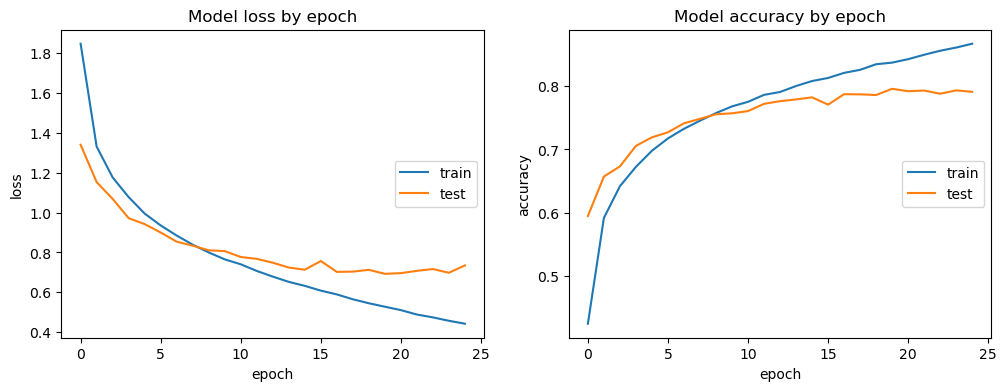

In [14]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

## On evalue la qualité de notre modèle

In [15]:
# Étape 1 : Prédire sur le test set
y_pred_probs = model.predict(test_ds)  # Probabilités
y_pred = np.argmax(y_pred_probs, axis=1)  # Classes prédites

# Étape 2 : Récupérer les vrais labels depuis le test set, dans le même ordre
y_true_check = []
for batch in test_ds:
    images, labels = batch
    y_true_check.extend(labels.numpy())

y_true = np.array(y_true_check)

# Étape 3 : Rapport de classification
print("\n Rapport de classification :")
print(classification_report(y_true, y_pred))



125/125 ━━━━━━━━━━━━━━━━━━━━ 118s 945ms/step

 Rapport de classification :
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       246
           1       0.71      0.51      0.59       251
           2       0.92      0.96      0.94       252
           3       0.89      0.92      0.90       253
           4       0.87      0.84      0.86       251
           5       0.64      0.54      0.58       250
           6       0.92      0.84      0.88       257
           7       0.76      0.91      0.83       247
           8       0.84      0.91      0.87       253
           9       0.83      0.86      0.85       246
          10       0.60      0.81      0.69       250
          11       0.74      0.80      0.77       248
          12       0.71      0.66      0.68       249
          13       0.88      0.50      0.64       243
          14       0.84      0.91      0.88       254
          15       0.76      0.87      0.81       249

    a

Matrice de confusion :


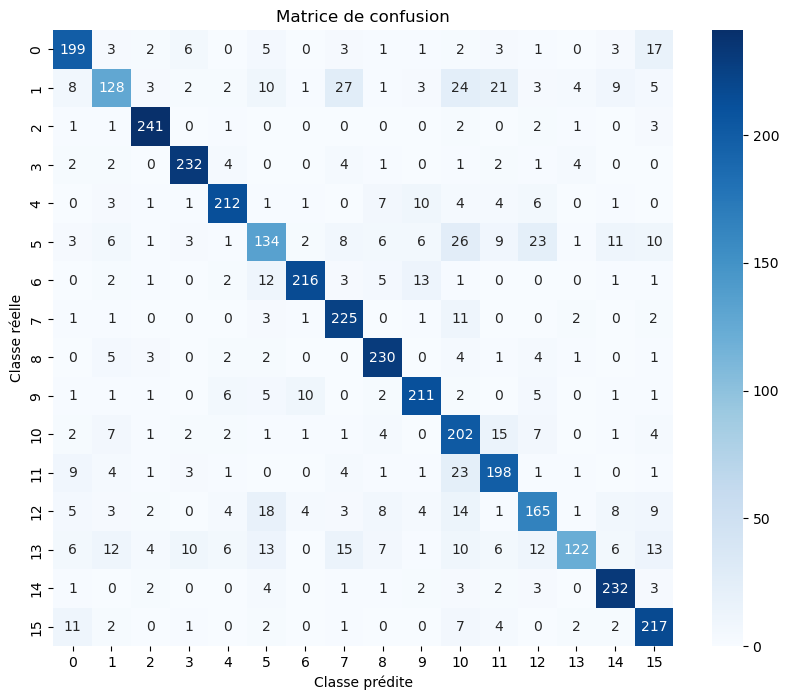

In [16]:
# Étape 4 : Matrice de confusion
print("Matrice de confusion :")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()